In [1]:
from elasticsearch import Elasticsearch
import json
import requests

import eslogin

import datetime
import time

import numpy as np
from numpy.random import randn
import pandas as pd
from scipy import stats
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import sklearn as sklearn

import plotly.plotly as py
from plotly.graph_objs import *

%matplotlib inline
mpl.style.use('ggplot')

pd.options.display.max_rows = 20
pd.options.display.max_columns = 30

In [187]:
print mpl.__version__

1.4.3


#Import data

In [105]:
clicks_uniq = pd.read_csv("../data/clicks_uniq_150610.tab",sep='\t',index_col=0,encoding='utf-8')
adShows_uniq = pd.read_csv("../data/adShows_uniq_150610.tab",sep='\t',index_col=0,encoding='utf-8')
duplicate_id = set(adShows_uniq['id']) - set(clicks_uniq['id'])
adShows_uniq_only = adShows_uniq.loc[adShows_uniq['id'].apply(lambda x: x in duplicate_id), :]

In [106]:
data = pd.concat([clicks_uniq[['ai','br','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','vw_drtn','vw_perc','cr','created_at','et']],adShows_uniq_only[['ai','br','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','vw_drtn','vw_perc','cr','created_at','et']]], axis=0)

In [107]:
def get_date(timestring):
    mytime = timestring.split('.')[0]
    return datetime.datetime.strptime(mytime, '%Y-%m-%dT%X')
data['created_at'] = data['created_at'].apply(get_date)

In [108]:
data2 = data[data['created_at'].apply(lambda x:(x.month == 5 or x.month == 6))]

In [109]:
data2['br_short'] = data2['br'].apply(lambda x:x.split()[0])
data2['click'] = data2['et'].apply(lambda x:x == 'AD_CLICK')

In [193]:
data2.shape

(18729, 19)

In [110]:
ad_type = pd.read_csv("../data/zenit_creatives_parsed.tab",sep='\t',encoding='utf-8')

In [195]:
ad_type.columns[0]

u'cr'

In [196]:
ad_type['ad_type'][ad_type['cr'].apply(lambda x: x == 157)].values[0]

u'tile_and_text'

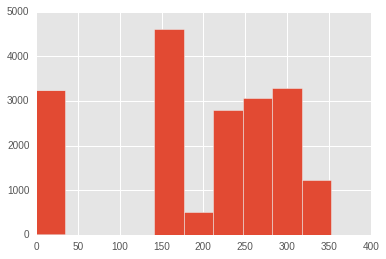

In [197]:
data2['cr'].hist()

In [198]:
data2['plfm'].value_counts()

ios        4928
android    4699
dtype: int64

In [199]:
def get_ad_type(cr_id):
    if cr_id > 0 and cr_id in ad_type['cr']:
        return ad_type['ad_type'][ad_type['cr'].apply(lambda x: x == cr_id)].values[0]
    else:
        return np.NaN
get_ad_type(157)

u'tile_and_text'

In [111]:
data2 = pd.merge(data2, ad_type, left_on ='cr', right_on ='cr', how='left')

In [112]:
data2['day'] = data2['created_at'].apply(lambda x:x.day)

In [113]:
data2['time'] = data2['created_at'].apply(lambda x:x.hour)

#Specify two apps

In [204]:
features = ['click','ai','cr','br_short','co','cty','rgn','plfm','pv','dt','sdpt','isp','ernc','dp','ad_type','day','time']

In [205]:
data2_app1 = data2.loc[data2['ai'].apply(lambda x:(x == 67 or x == 68)),features]

In [206]:
data2_app1.shape

(1163, 17)

In [207]:
800.0/1163

0.6878761822871883

In [208]:
data2_app1['click'].value_counts()

True     669
False    494
dtype: int64

In [209]:
data2_app2 = data2.loc[data2['ai'].apply(lambda x:(x == 53 or x == 54)),features]

In [210]:
data2_app2.shape

(2584, 17)

In [211]:
data2_app2['click'].value_counts()

False    2156
True      428
dtype: int64

In [212]:
data2_app3 = data2.loc[data2['ai'].apply(lambda x:(x == 71 or x == 72 or x == 88)),features]

#Machine learning for DC

In [213]:
data2_app1.index = range(data2_app1.shape[0])

In [215]:
data2_app1_expand = pd.concat([data2_app1[['click']],pd.get_dummies(data2_app1['br_short'], dummy_na=True, prefix='br'),
                                         pd.get_dummies(data2_app1['co'], dummy_na=True, prefix='co'),
                                         pd.get_dummies(data2_app1['cty'].apply(cty_parser), dummy_na=True, prefix='cty'),
                                         pd.get_dummies(data2_app1['rgn'], dummy_na=True, prefix='rgn'),
                                         pd.get_dummies(data2_app1['plfm'], dummy_na=True, prefix='plfm'),
                                         pd.get_dummies(data2_app1['pv'], dummy_na=True, prefix='pv'),
                                         pd.get_dummies(data2_app1['dt'], dummy_na=True, prefix='dt'),
                                         pd.get_dummies(data2_app1['isp'], dummy_na=True, prefix='isp'),
                                         pd.get_dummies(data2_app1['ad_type'], dummy_na=True, prefix='ad_type'),
                                         data2_app1[['ai','sdpt','day','time','ernc','dp']]],axis=1)

In [216]:
data2_app1_expand.shape

(1163, 370)

In [217]:
train_app1_Ind = np.random.choice(data2_app1.shape[0], size=800, replace=False)

In [218]:
train_app1 = data2_app1_expand.loc[train_app1_Ind,:]

In [219]:
testapp1_Ind = []
for i in range(data2_app1.shape[0]):
    if not i in train_app1_Ind:
        test_app1_Ind.append(i)
len(testapp1_Ind)

363

In [220]:
test_app1 = data2_app1_expand.loc[test_app1_Ind,:]

In [222]:
train_app1_data = train_app1.values

In [223]:
forest = RandomForestClassifier(n_estimators = 100)

In [224]:
forest_app1 = forest.fit(train_app1_data[0::,1::],train_app1_data[0::,0])

In [225]:
test_app1_data = test_app1.values

In [226]:
predict_app1 = forest.predict(test_app1_data[0::,1::])

In [227]:
def error_analysis(predict, reality):
    accuracy = float(np.sum(predict == reality))/len(reality) * 100
    precision = float(np.sum((reality == 1)*(reality == predict)))/np.sum(predict == 1) * 100
    recall = float(np.sum((reality == 1)*(reality == predict)))/np.sum(reality == 1) * 100
    f1score = 2*precision*recall/(precision + recall)/100
    print 'accuracy:%.2f\nprecision:%.2f\nrecall:%.2f\nF1 score:%.2f' % (accuracy, precision, recall, f1score)
error_analysis(predict_app1, test_app1_data[0::,0])

accuracy:95.87
precision:95.43
recall:96.91
F1 score:0.96


In [228]:
predict_app1_train = forest.predict(train_app1_data[0::,1::])

In [229]:
error_analysis(predict_app1_train, train_app1_data[0::,0])

accuracy:99.88
precision:100.00
recall:99.79
F1 score:1.00


# Feature importance for DC

In [230]:
importances_app1 = forest_app1.feature_importances_
std_app1 = np.std([tree.feature_importances_ for tree in forest_app1.estimators_],axis=0)
indices_app1 = np.argsort(importances_app1)[::-1]

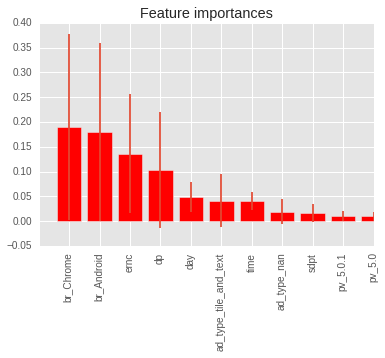

In [231]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importancesapp1)), importances_app1[indices_app1],
       color="r", yerr=std_app1[indices_app1], align="center")
plt.xticks(range(len(importances_app1)), train_app1.columns[1:][indices_app1],
           rotation='vertical')
plt.xlim([-1, 10])
plt.show()

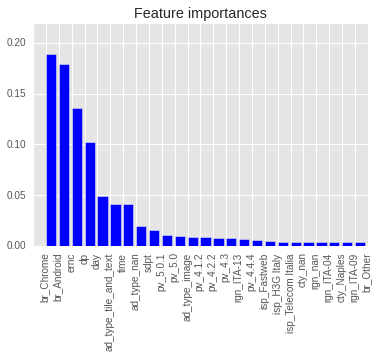

In [232]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances_app1)), importances_app1[indicesapp1],color="b")
plt.xticks(range(len(importances_app1)), train_app1.columns[1:][indices_app1],
           rotation='vertical')
plt.xlim([-1, 25])
plt.ylim([0, 0.22])
plt.savefig("../fig/20150614_RF_feature_top_25_app1.png",format='png')

^browser type plays essential role!

In [233]:
features_app1 = pd.DataFrame({'feature': train_app1.columns.values[1:],
                                        'importance': importances_app1,
                                        'type': [x.split('_')[0] for x in train_app1.columns.values[1:]]},
                                       index = range(len(importances_app1)))

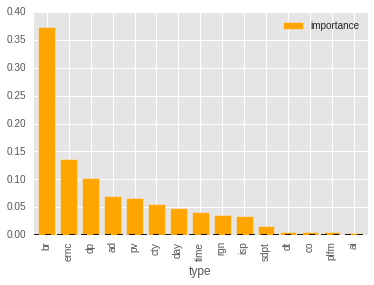

In [234]:
p = features_app1[['type',
                             'importance']].groupby('type').sum().sort('importance',
                                                                       ascending = 0).plot(kind='bar',
                                                                                           color='orange')
fig = p.get_figure()
fig.savefig('../fig/20150614_RF_feature_sum_app1.png',format='png')

In [235]:
rate_app1 = float(data2_app1.click.sum())/data2_app1.shape[0]
rate_app1

0.5752364574376613

In [236]:
br_ctr_app1 = data2_app1.groupby('br_short').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_app1).apply(lambda x: np.log2(x+0.001))
br_ctr_app1.sort(ascending = False)
br_ctr_app1

br_short
Opera       0.798603
Chrome      0.798603
Other      -0.200568
...
Opera       0.798603
Chrome      0.798603
Other      -0.200568
Android    -1.530531
Length: 4, dtype: float64

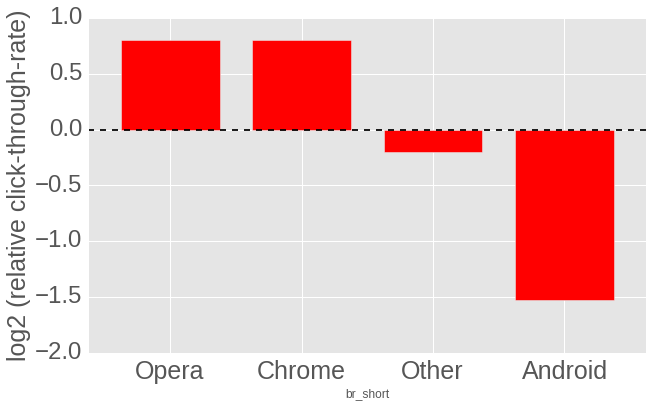

In [237]:
plt.figure(figsize=(10,6))
p = br_ctr_app1.plot(kind='bar',color='r')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=25)
plt.setp(p.get_yticklabels(), fontsize=24)
fig = p.get_figure()
fig.savefig('../fig/20150614_CTR_by_br_sort_app1.png',format='png')

Although Android wins overall, it shows opposite trend for this specific app - interesting...

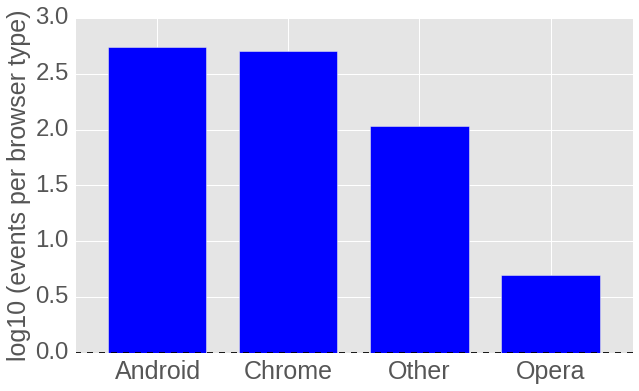

In [238]:
br_counts_app1 = data2_app1['br_short'].value_counts()
plt.figure(figsize=(10,6))
p = np.log10(br_counts_app1[br_counts_app1.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per browser type)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=25)
plt.setp(p.get_yticklabels(), fontsize=24)
#plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150614_et_by_br_sort_app1.png',format='png')

Not many cases in Opera. Chrome beats Android here.

Just want to confirm a bit:

In [239]:
data2_app1['click'][data2_app1['br_short'] == 'Android'].value_counts()

False    440
True     109
dtype: int64

In [240]:
data2_app1['co'].value_counts()

ITA    1128
USA      18
GBR       5
BEL       3
DEU       3
MAR       1
ESP       1
FRA       1
SAU       1
CAN       1
...
ITA    1128
USA      18
GBR       5
BEL       3
DEU       3
MAR       1
ESP       1
FRA       1
SAU       1
CAN       1
NGA       1
Length: 11, dtype: int64

It's dominate Italy - that's why ITA associated with higher CTR?

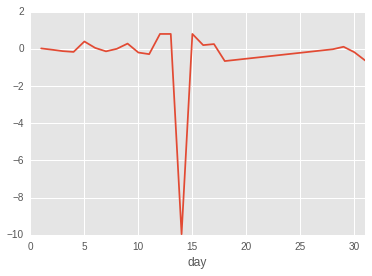

In [241]:
data2_app1.groupby('day').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Diretta_Calcio).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(0,31))

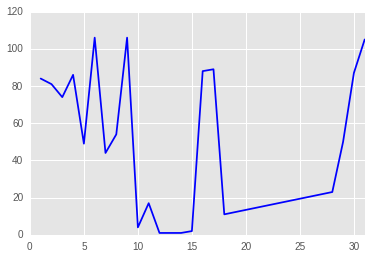

In [242]:
data2_app1['day'].value_counts().sort_index().plot(color="b",xlim=(0,31))

The date of each month is not important for CTR

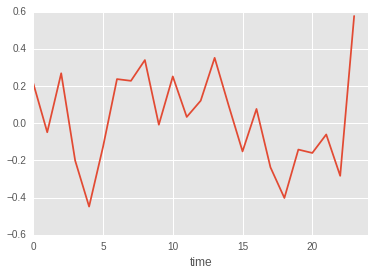

In [243]:
data2_app1.groupby('time').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_app1).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(0,24))

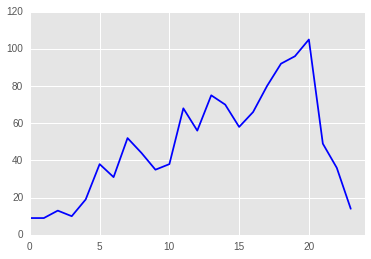

In [244]:
data2_app1['time'].value_counts().sort_index().plot(color="b",xlim=(0,24))

More ads should be released at 6am-1pm (morning) or around midnight? - or anti-correlated?

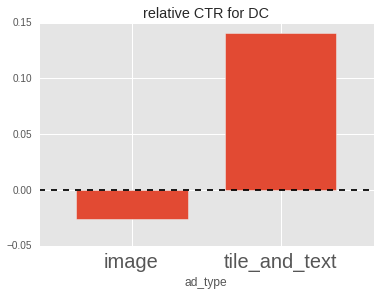

In [245]:
data2_app1.groupby('ad_type').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Diretta_Calcio).apply(lambda x: np.log2(x+0.001)).sort_index().plot(kind='bar',rot='horizontal',fontsize=20, title='relative CTR for DC')

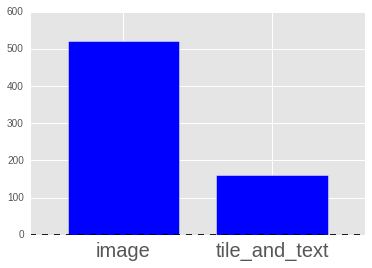

In [246]:
data2_app1['ad_type'].value_counts().plot(kind='bar',rot='horizontal',fontsize=20,color="b")

In [247]:
breaks = range(0,120,2)
sdpt_ctr_app1 = []
for i in breaks:
    sdpt_ctr_app1.append(float(data2_app1[data2_app1['sdpt'].apply(lambda x:x < i)].click.sum())/(data2app1[data2_app1['sdpt'].apply(lambda x:x < i)].shape[0] + 0.001))

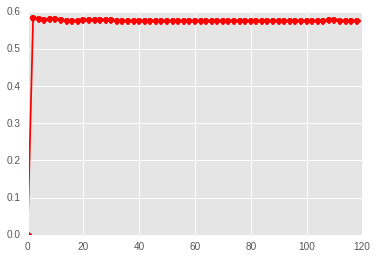

In [248]:
plt.plot(breaks, sdpt_ctr_app1, 'ro-')

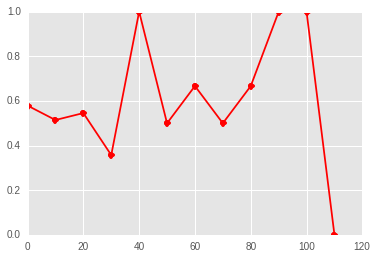

In [249]:
step = 10
breaks = range(0,120,step)
sdpt_ctr_app1 = []
for i in breaks:
    sdpt_ctr_app1.append(float(data2_app1[data2_app1['sdpt'].apply(lambda x:(x >= i and x < i + step))].click.sum())/(data2_app1[data2_app1['sdpt'].apply(lambda x:(x >= i and x < i + step))].shape[0] + 0.001))
plt.plot(breaks, sdpt_ctr_app1, 'ro-')

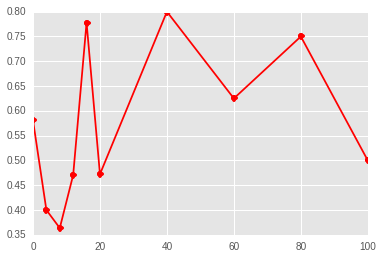

In [250]:
step1 = 4
step2 = 20
breaks1 = range(0,20,step1)
breaks2 = range(20,120,step2)
sdpt_ctr_app1 = []
for i in breaks1:
    sdpt_ctr_app1.append(float(data2_app1[data2_app1['sdpt'].apply(lambda x:(x >= i and x < i + step1))].click.sum())/(data2_app1[data2_app1['sdpt'].apply(lambda x:(x >= i and x < i + step1))].shape[0] + 0.001))
for i in breaks2:
    sdpt_ctr_app1.append(float(data2_app1[data2_app1['sdpt'].apply(lambda x:(x >= i and x < i + step2))].click.sum())/(data2_app1[data2_app1['sdpt'].apply(lambda x:(x >= i and x < i + step2))].shape[0] + 0.001))
breaks = breaks1 + breaks2
plt.plot(breaks, sdpt_ctr_app1, 'ro-')

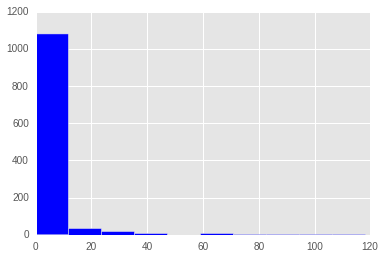

In [251]:
data2_app1['sdpt'].hist(color="b")

In [370]:
data2[data2['ai'] == 67]['plfm'].value_counts()

android    1049
dtype: int64

In [371]:
data2[data2['ai'] == 68]['plfm'].value_counts()

Series([], dtype: int64)

There's no obvious "trend" for sdpt here

#Machine learning for Team Manchester

In [252]:
data2_app2.index = range(data2_app2.shape[0])

In [253]:
data2_app2_expand = pd.concat([data2_app2[['click']],
                                         pd.get_dummies(data2_app2['br_short'], dummy_na=True, prefix='br'),
                                         pd.get_dummies(data2_app2['co'], dummy_na=True, prefix='co'),
                                         pd.get_dummies(data2_app2['cty'].apply(cty_parser), dummy_na=True, prefix='cty'),
                                         pd.get_dummies(data2_app2['rgn'], dummy_na=True, prefix='rgn'),
                                         pd.get_dummies(data2_app2['plfm'], dummy_na=True, prefix='plfm'),
                                         pd.get_dummies(data2_app2['pv'], dummy_na=True, prefix='pv'),
                                         pd.get_dummies(data2_app2['dt'], dummy_na=True, prefix='dt'),
                                         pd.get_dummies(data2_app2['isp'], dummy_na=True, prefix='isp'),
                                         pd.get_dummies(data2_app2['ad_type'], dummy_na=True, prefix='ad_type'),
                                         data2_app2[['ai','sdpt','day','time','ernc','dp']]],axis=1)

In [254]:
data2_app2_expand.shape

(2584, 1504)

In [255]:
2584.0 * 0.7

1808.8

In [256]:
train_app2_Ind = np.random.choice(data2_app2.shape[0], size=1800, replace=False)

In [257]:
test_app2_Ind = []
for i in range(data2_app2.shape[0]):
    if not i in train_app2_Ind:
        test_app2_Ind.append(i)
len(test_app2_Ind)

784

In [258]:
train_app2 = data2_app2_expand.loc[train_app2_Ind,:]
test_app2 = data2_app2_expand.loc[test_app2_Ind,:]

In [259]:
train_app2_data = train_app2.values
test_app2_data = test_app2.values

In [260]:
forest = RandomForestClassifier(n_estimators = 100)
forest_app2 = forest.fit(train_app2_data[0::,1::],train_app2_data[0::,0])
predict_app2_train = forest.predict(train_app2_data[0::,1::])
predict_app2_test = forest.predict(test_app2_data[0::,1::])

In [261]:
error_analysis(predict_app2_train, train_app2_data[0::,0])

accuracy:100.00
precision:100.00
recall:100.00
F1 score:1.00


In [262]:
error_analysis(predict_app2_test, test_app2_data[0::,0])

accuracy:90.69
precision:91.78
recall:50.00
F1 score:0.65


#Feature importance for TM (app2)

In [263]:
importances_app2 = forest_app2.feature_importances_
std_app2 = np.std([tree.feature_importances_ for tree in forest_app2.estimators_],axis=0)
indices_app2 = np.argsort(importances_app2)[::-1]

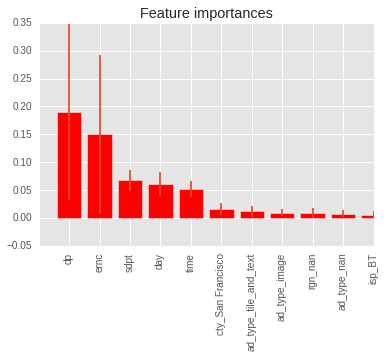

In [264]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances_app2)), importances_app2[indices_app2],
       color="r", yerr=std_app2[indices_app2], align="center")
plt.xticks(range(len(importances_app2)), train_app2.columns[1:][indices_app2],
           rotation='vertical')
plt.xlim([-1, 10])
plt.show()

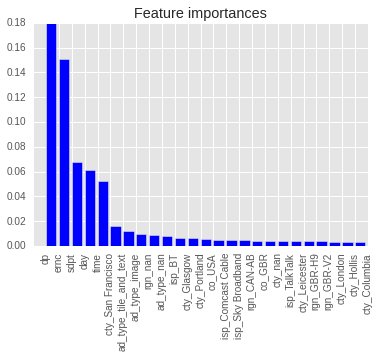

In [265]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(importances_app2)), importances_app2[indices_app2],color="b")
plt.xticks(range(len(importances_app2)), train_app2.columns[1:][indices_app2],
           rotation='vertical')
plt.xlim([-1, 25])
plt.ylim([0, 0.18])
plt.savefig("../fig/20150614_RF_feature_top_25_app2.png",format='png')

In [266]:
features_app2 = pd.DataFrame({'feature': train_app2.columns.values[1:],
                                    'importance': importances_app2,
                                    'type': [x.split('_')[0] for x in train_app2.columns.values[1:]]},
                                    index = range(len(importances_app2)))

In [268]:
data2_app2['br_short'].value_counts()

Other       2583
Internet       1
dtype: int64

"browser" is not informative for the case here. Geo, time, and other features seem to be more important.

In [269]:
rate_app2 = float(data2_app2.click.sum())/data2_app2.shape[0]
rate_app2

0.16563467492260062

CTR is also much lower than DC

In [ ]:
ctr_cty_app2.sort(ascending = False)

In [ ]:
plt.figure(figsize=(20,5))
p = ctr_cty_app2.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=5)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150614_CTR_by_cty_app2.png',format='png')

A few cities show higher CTR and most show lower than average CTR

In [ ]:
ctr_rgn_app2 = data2_app2.groupby('rgn').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_app2).apply(lambda x: np.log2(x+0.001))
ctr_rgn_app2.sort(ascending = False)
plt.figure(figsize=(20,5))
p = ctr_rgn_app2.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=5)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150614_CTR_by_rgn_app2.png',format='png')

In [ ]:
data2_app2['co'].value_counts()

This app is more global

In [ ]:
ctr_co_app2 = data2_app2.groupby('co').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_app2).apply(lambda x: np.log2(x+0.001))
ctr_co_app2.sort(ascending = False)
plt.figure(figsize=(20,5))
p = ctr_co_app2.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=20)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150614_CTR_by_co_app2.png',format='png')

In [ ]:
co_counts_app2 = data2_app2['co'].value_counts()
plt.figure(figsize=(20,5))
p = np.log10(co_counts_app2[ctr_co_app2.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per country)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=20)
plt.setp(p.get_yticklabels(), fontsize=20)
plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150614_et_by_co_app2.png',format='png')

In [ ]:
data2_app2.groupby('day').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Team_Manchester).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(0,31))

In [ ]:
data2_app2['day'].value_counts().sort_index().plot(color="b",xlim=(0,31))

In [ ]:
data2_app2.groupby('time').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_Team_Manchester).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(0,23))

In [ ]:
data2_app2['time'].value_counts().sort_index().plot(color="b",xlim=(0,23))

In [ ]:
data2_app2.groupby('ad_type').apply(lambda x:float(x.click.sum())/x.shape[0]/rate_app2).apply(lambda x: np.log2(x+0.001)).sort_index().plot(kind='bar',rot='horizontal',fontsize=20, title='relative CTR for TM')

In [ ]:
data2_app2['ad_type'].value_counts().sort_index().plot(kind='bar',rot='horizontal',fontsize=20,color="b")

In [ ]:
step1 = 5
step2 = 40
breaks1 = range(0,60,step1)
breaks2 = range(60,200,step2)
sdpt_ctr_app2 = []
for i in breaks1:
    sdpt_ctr_app2.append(float(data2_app2[data2_app2['sdpt'].apply(lambda x:(x >= i and x < i + step1))].click.sum())/(data2_app2[data2_app2['sdpt'].apply(lambda x:(x >= i and x < i + step1))].shape[0] + 0.001))
for i in breaks2:
    sdpt_ctr_app2.append(float(data2_app2[data2_app2['sdpt'].apply(lambda x:(x >= i and x < i + step2))].click.sum())/(data2_app2[data2_app2['sdpt'].apply(lambda x:(x >= i and x < i + step2))].shape[0] + 0.001))
breaks = breaks1 + breaks2
plt.plot(breaks, sdpt_ctr_app2, 'ro-')

In [ ]:
data2_app2['sdpt'].hist(color="b")

Maybe sdpt < 50?

#All apps

In [ ]:
rate = float(data2.click.sum())/data2.shape[0]
rate

In [ ]:
data2.groupby('time').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(-.5,23.5), title='relative CTR')

In [ ]:
data2['time'].value_counts().sort_index().plot(color="b",xlim=(-.5,23.5), title='total number of events')

Overall, there's anti-corelation between the amount of events and CTR..

In [ ]:
data2['time'][data2['click']].value_counts().sort_index().plot(color="g",xlim=(-.5,23.5), title='click events')

timestamp here are all in UTC

In [ ]:
data2.groupby('day').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(-.5,31.5))

In [ ]:
data2['day'].value_counts().sort_index().plot(color="b",xlim=(-.5,31.5))

In [ ]:
data2.groupby('ad_type').apply(lambda x:float(x.click.sum())/x.shape[0]/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(kind='bar',rot='horizontal',fontsize=20)

In [ ]:
data2['ad_type'].value_counts().sort_index().plot(kind='bar',rot='horizontal',fontsize=20,color="b",logy=True)

In [ ]:
step1 = 5
step2 = 20
breaks1 = range(0,60,step1)
breaks2 = range(60,200,step2)
sdpt_ctr = []
for i in breaks1:
    sdpt_ctr.append(float(data2[data2['sdpt'].apply(lambda x:(x >= i and x < i + step1))].click.sum())/(data2[data2['sdpt'].apply(lambda x:(x >= i and x < i + step1))].shape[0] + 0.001))
for i in breaks2:
    sdpt_ctr.append(float(data2[data2['sdpt'].apply(lambda x:(x >= i and x < i + step2))].click.sum())/(data2[data2['sdpt'].apply(lambda x:(x >= i and x < i + step2))].shape[0] + 0.001))
breaks = breaks1 + breaks2
plt.plot(breaks, sdpt_ctr, 'ro-')

In [ ]:
data2['sdpt'].hist(color="b")

Pattern for all data is different from the previous two apps

# Correct for uneven sampling

In [ ]:
impression_sample_rate = float(19872)/4584942
impression_sample_rate

In [308]:
rate = float(data2.click.sum())/((~data2.click).sum()/impression_sample_rate + data2.click.sum())
rate

0.0017455627064941754

In [351]:
rate_app1 = float(data2_app1.click.sum())/((~data2_app1.click).sum()/impression_sample_rate + data2_app1.click.sum())
rate_app1

0.0058353273983402136

In [352]:
rate_app2 = float(data2_app2.click.sum())/((~data2_app2.click).sum()/impression_sample_rate + data2_app2.click.sum())
rate_app2

0.00085966498230947183

In [353]:
rate_app3 = float(data2_app3.click.sum())/((~data2_app3.click).sum()/impression_sample_rate + data2_app3.click.sum())
rate_app3

0.005703706238003905

In [ ]:
data2.groupby('time').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(-.5,23.5), title='relative CTR (corrected)')

In [ ]:
data2.groupby('time').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate)/rate).apply(lambda x: np.log2(x+0.001)).sort_index().plot(xlim=(-.5,23.5), title='relative CTR (round)')

Well the shape looks pretty similar with the old plot, but just the "amplitude" changes

In [ ]:
co_ctr = data2.groupby('co').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())/rate).apply(lambda x: np.log2(x+0.001))
co_ctr.sort(ascending = False)
plt.figure(figsize=(20,5))
p = co_ctr.plot(kind='bar',color='orange')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=15)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150615_CTR_by_co_sort_corrected.png',format='png')

In [ ]:
co_counts = data2.groupby('co').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate))
plt.figure(figsize=(20,5))
p = np.log10(co_counts[co_ctr.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per country)', fontsize=20)
plt.setp(p.get_xticklabels(), rotation='vertical', fontsize=15)
plt.setp(p.get_yticklabels(), fontsize=20)
plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150615_et_by_co_sort_corrected.png',format='png')

In [ ]:
br_ctr = data2.groupby('br_short').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())/rate).apply(lambda x: np.log2(x+0.001))
br_ctr.sort(ascending = False)
plt.figure(figsize=(20,5))
p = br_ctr.plot(kind='bar',color='r')
p.set_ylabel('log2 (relative click-through-rate)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
fig = p.get_figure()
fig.savefig('../fig/20150615_CTR_by_br_sort_corrected.png',format='png')

In [ ]:
br_counts = data2.groupby('br_short').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate))
plt.figure(figsize=(20,5))
p = np.log10(br_counts[br_ctr.index]).plot(kind='bar',color='b')
p.set_ylabel('log10 (events per browser type)', fontsize=25)
plt.setp(p.get_xticklabels(), rotation='horizontal', fontsize=22)
plt.setp(p.get_yticklabels(), fontsize=20)
#plt.gca().invert_yaxis()
fig = p.get_figure()
fig.savefig('../fig/20150615_et_by_br_sort_corrected.png',format='png')

In [ ]:
check_br = data2.groupby('br_short').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_br.sort(ascending = False)
pd.DataFrame({'ctr':check_br,'cnt':data2['br_short'].value_counts()})

#How to explain the difference in browser and location?

First I want to examine the difference in each app systematically:

In [ ]:
plt.figure(figsize=(20,5))
p = data2.groupby('ai').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,5000000),title='number of events per app')
p.set_yscale('log')

DC: 67/68 TM: 53/54 are the ones with more events

High CTR: 67,87,93

Low CTR: 49,51,54,115,116

In [ ]:
plt.figure(figsize=(20,5))
p = data2.groupby('ai').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.04),title='CTR')
plt.axhline(y=rate)

I want to calculate the proportion of each type of browser for each app

In [ ]:
aid = 89
check_ai_br = data2[data2['ai'] == aid].groupby('br_short').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_ai_br.sort(ascending = False)
pd.DataFrame({'ctr':check_ai_br,'cnt':data2[data2['ai'] == aid]['br_short'].value_counts()})

In [416]:
aid = 72
check_co_br = data2[data2['ai'] == aid].groupby('co').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_co_br.sort(ascending = False)
pd.DataFrame({'ctr':check_co_br,'cnt':data2[data2['ai'] == aid]['co'].value_counts()})

,cnt,ctr
ITA,50,0.005062
UKR,7,0.025346


My questions:

I wonder why some apps/ads are better than the others?...

Any good paring for ads/apps?

#More controlled comparison with platform/browser and geo-location

Android vs iOS

67 vs 68

72 vs 71

Too much ad_show data: can use the precalculated event count table

In [362]:
df_show = pd.read_csv("../data/ad_show_count_150617.tab",sep='\t',index_col=0)
df_click = pd.read_csv("../data/ad_click_count_150617.tab",sep='\t',index_col=0)

Advertisement on both 67 and 68:

In [372]:
ads67 = df_show['67'][df_show['67'] > 0].index

In [373]:
ads68 = df_show['68'][df_show['68'] > 0].index

In [382]:
inter_set_67_68 = set(ads67) - (set(ads67) - set(ads68))

In [383]:
len(inter_set_67_68)

17

In [384]:
index = []
for i in inter_set_67_68:
    index.append(i)

In [385]:
cmp1 = pd.DataFrame(index=index, columns=['67_show','67_click','68_show','68_click'])
cmp1 = cmp1.fillna(0)

In [393]:
for i in index:
    cmp1.loc[i, '67_show'] = df_show.loc[i, '67']
    cmp1.loc[i, '67_click'] = df_click.loc[i, '67']
    cmp1.loc[i, '68_show'] = df_show.loc[i, '68']
    cmp1.loc[i, '68_click'] = df_click.loc[i, '68']

In [396]:
cmp1['67_rate'] = cmp1['67_click'] / cmp1['67_show']

In [398]:
cmp1['68_rate'] = cmp1['68_click'] / cmp1['68_show']

In [408]:
cmp1_sub = cmp1[cmp1['67_show'] > 5]
cmp1_sub = cmp1_sub[cmp1_sub['68_show'] > 5]
cmp1_sub

,67_show,67_click,68_show,68_click,67_rate,68_rate
246,77,0,9,0,0.000000,0.000000
292,13,0,29,0,0.000000,0.000000
293,18,0,27,0,0.000000,0.000000
327,197,0,32,0,0.000000,0.000000
330,39448,266,9,0,0.006743,0.000000
334,232,0,11,0,0.000000,0.000000
349,271,0,40,0,0.000000,0.000000
350,167,0,39,1,0.000000,0.025641
342,630,5,78,0,0.007937,0.000000
156,51,1,53,0,0.019608,0.000000


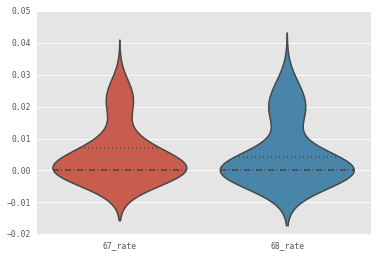

In [409]:
sns.violinplot(cmp1_sub[['67_rate','68_rate']])

Try to get more data historically, and only 'ITA' (restrict another variable):

In [410]:
cmp2 = pd.DataFrame(index=index, columns=['67_show','67_click','68_show','68_click'])
cmp2 = cmp2.fillna(0)

In [417]:
for i in index:
    cmp2.loc[i, '67_show'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'ai' : 67 }}, {'match': { 'cr' : i }}, {'match': { 'et' : 'AD_SHOW' }}, {'match': { 'co' : 'ITA' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
    cmp2.loc[i, '67_click'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'ai' : 67 }}, {'match': { 'cr' : i }}, {'match': { 'et' : 'AD_CLICK' }}, {'match': { 'co' : 'ITA' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
    cmp2.loc[i, '68_show'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'ai' : 68 }}, {'match': { 'cr' : i }}, {'match': { 'et' : 'AD_SHOW' }}, {'match': { 'co' : 'ITA' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
    cmp2.loc[i, '68_click'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'ai' : 68 }}, {'match': { 'cr' : i }}, {'match': { 'et' : 'AD_CLICK' }}, {'match': { 'co' : 'ITA' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

In [422]:
cmp2['67_rate'] = cmp2['67_click'] / cmp2['67_show']
cmp2['68_rate'] = cmp2['68_click'] / cmp2['68_show']

In [424]:
cmp2_sub = cmp2[cmp2['67_show'] > 5]
cmp2_sub = cmp2_sub[cmp2_sub['68_show'] > 5]
cmp2_sub

,67_show,67_click,68_show,68_click,67_rate,68_rate
246,76,0,9,0,0.000000,0.000000
327,208,0,29,0,0.000000,0.000000
330,42177,286,9,0,0.006781,0.000000
334,240,0,10,0,0.000000,0.000000
349,283,0,38,0,0.000000,0.000000
350,212,0,23,1,0.000000,0.043478
342,620,4,78,0,0.006452,0.000000


That's not interesting...

In [425]:
ads71 = df_show['71'][df_show['71'] > 0].index
ads72 = df_show['72'][df_show['72'] > 0].index

In [426]:
inter_set_71_72 = set(ads71) - (set(ads71) - set(ads72))
len(inter_set_71_72)

8

In [427]:
index2 = []
for i in inter_set_71_72:
    index2.append(i)
index2

[327, 334, 339, 342, 281, 283, 349, 350]

In [431]:
cmp3 = pd.DataFrame(index=index2, columns=['71_show','71_click','72_show','72_click'])
cmp3 = cmp3.fillna(0)
for i in index2:
    cmp3.loc[i, '71_show'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'ai' : 71 }}, {'match': { 'cr' : i }}, {'match': { 'et' : 'AD_SHOW' }}, {'match': { 'co' : 'ITA' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
    cmp3.loc[i, '71_click'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'ai' : 71 }}, {'match': { 'cr' : i }}, {'match': { 'et' : 'AD_CLICK' }}, {'match': { 'co' : 'ITA' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
    cmp3.loc[i, '72_show'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'ai' : 72 }}, {'match': { 'cr' : i }}, {'match': { 'et' : 'AD_SHOW' }}, {'match': { 'co' : 'ITA' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
    cmp3.loc[i, '72_click'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'ai' : 72 }}, {'match': { 'cr' : i }}, {'match': { 'et' : 'AD_CLICK' }}, {'match': { 'co' : 'ITA' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
cmp3

,71_show,71_click,72_show,72_click
327,258,5,10,0
334,149,3,0,0
339,0,0,0,0
342,1,0,0,0
281,47,5,143,2
283,30,3,143,1
349,1482,12,0,0
350,595,6,136,0


In [432]:
cmp3['71_rate'] = cmp3['71_click'] / cmp3['71_show']
cmp3['72_rate'] = cmp3['72_click'] / cmp3['72_show']
cmp3

,71_show,71_click,72_show,72_click,71_rate,72_rate
327,258,5,10,0,0.019380,0.000000
334,149,3,0,0,0.020134,inf
339,0,0,0,0,inf,inf
342,1,0,0,0,0.000000,inf
281,47,5,143,2,0.106383,0.013986
283,30,3,143,1,0.100000,0.006993
349,1482,12,0,0,0.008097,inf
350,595,6,136,0,0.010084,0.000000


Looks like the trend is opposite here...

# Correlation between browser and location?

In [418]:
co = 'NGA'
check_cor = data2[data2['co'] == co].groupby('br_short').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_cor.sort(ascending = False)
pd.DataFrame({'ctr':check_cor,'cnt':data2[data2['co'] == co]['br_short'].value_counts()})

,cnt,ctr
Android,396,0.009202
BlackBerry,56,0.007741
Chrome,354,0.004996
Firefox,61,0.000224
Internet,2,1.000000
Opera,39,0.002702
Other,44,0.002992
Safari,945,0.004234
iPad,18,0.004315
iPhone,109,0.006126


In [433]:
co = 'NGA'
check_cor = data2[data2['co'] == co].groupby('plfm').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
check_cor.sort(ascending = False)
pd.DataFrame({'ctr':check_cor,'cnt':data2[data2['co'] == co]['plfm'].value_counts()})

,cnt,ctr
android,685,0.007675
ios,129,0.005798


Seem to be somehow correlated...

In [ ]:
co_ctr = data2.groupby('co').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum()))
co_anroid_iphone = data2.groupby('co').apply(lambda x:float(x[x['br_short'] == 'Android'].shape[0])/(x[x['br_short'] == 'iPhone'].shape[0] + 0.01))
pd.DataFrame({'ctr':co_ctr,'br_rate':co_anroid_iphone}).plot(kind='scatter',x='br_rate',y='ctr',ylim=(-.02,.06),xlim=(-50,420))

No they are not correclated across all countries...

What to look at it in a different way:

In [484]:
countries = ['ITA','GBR','NGA','USA']
platforms = ['android','ios']
cmp_co = pd.DataFrame(index=countries, columns=['android','ios','show','click','ctr'])
cmp_co = cmp_co.fillna(0)
for col in platforms:
    for ind in countries:
        cmp_co.loc[ind,col] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : ind }}, {'match': { 'plfm' : col }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

In [437]:
for co in countries:
    cmp_co.loc[co, 'show'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : co }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
    cmp_co.loc[co, 'click'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : co }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

In [439]:
cmp_co = cmp_co[['android','ios','show','click','ctr']]
cmp_co.loc[:,'ctr'] = cmp_co['click'] / cmp_co['show']
cmp_co

,android,ios,show,click,ctr
ITA,347836,657,463172,2224,0.004802
GBR,45299,24246,1486800,4617,0.003105
NGA,169955,37855,580580,1833,0.003157
USA,287950,1069349,2110402,1287,0.000610


In [457]:
cmp_co['area'] = np.pi * (15 * np.round(cmp_co['ctr']*3000))**2 
cmp_co

,android,ios,show,click,ctr,area
ITA,347836,657,463172,2224,0.004802,138544.236023
GBR,45299,24246,1486800,4617,0.003105,57255.526112
NGA,169955,37855,580580,1833,0.003157,57255.526112
USA,287950,1069349,2110402,1287,0.000610,2827.433388


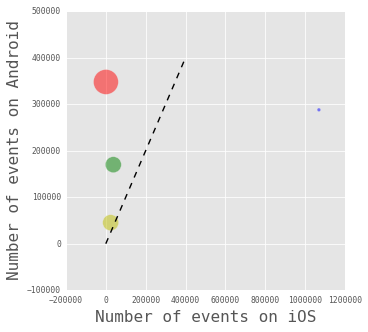

In [471]:
cmp_co['area'] = np.pi * (np.round(cmp_co['ctr']*3000))**2
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(cmp_co['ios'],cmp_co['android'],s=cmp_co['area'],c=['r','y','g','b'],alpha=0.5)
ax.set_ylabel('Number of events on Android',fontsize=16)
ax.set_xlabel('Number of events on iOS',fontsize=16)
plt.plot([0,400000], [0,400000], 'k--')

In [482]:
countries2 = data2['co'].value_counts()[:10].index.values

In [485]:
cmp_co2 = pd.DataFrame(index=countries2, columns=['android','ios','show','click','ctr'])
cmp_co2 = cmp_co.fillna(0)
for col in platforms:
    for ind in countries2:
        cmp_co2.loc[ind,col] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : ind }}, {'match': { 'plfm' : col }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

In [486]:
for co in countries2:
    cmp_co2.loc[co, 'show'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : co }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
    cmp_co2.loc[co, 'click'] = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : co }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

In [487]:
#cmp_co2 = cmp_co2[['android','ios','show','click','ctr']]
cmp_co2.loc[:,'ctr'] = cmp_co2['click'] / cmp_co2['show']
cmp_co2

,android,ios,show,click,ctr
ITA,347868,657,463225,2224,0.004801
GBR,45299,24246,1487042,4617,0.003105
NGA,170062,37855,580809,1834,0.003158
USA,287957,1069352,2110630,1287,0.000610
CAN,10866,27322,105509,62,0.000588
AUS,998,2535,129905,115,0.000885
SGP,298,31,101535,50,0.000492
IRL,2535,467,53476,75,0.001402
ZAF,11429,1278,58286,85,0.001458
GHA,10052,4864,35764,78,0.002181


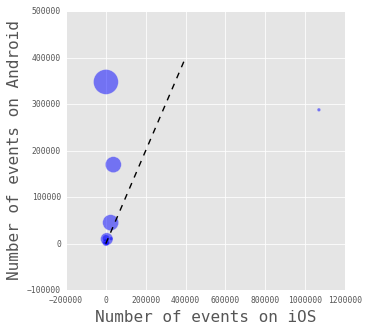

In [488]:
cmp_co2['area'] = np.pi * (np.round(cmp_co2['ctr']*3000))**2
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(np.log10(cmp_co2['ios']),cmp_co2['android'],s=cmp_co2['area'],alpha=0.5)
ax.set_ylabel('Number of events on Android',fontsize=16)
ax.set_xlabel('Number of events on iOS',fontsize=16)
plt.plot([0,400000], [0,400000], 'k--')

#Calculate the Android vs iOS for the corrected dataset

In [2]:
es = Elasticsearch([{'host': eslogin.host, 'port': eslogin.port}],http_auth=(eslogin.user,eslogin.password))

In [490]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

924021

In [491]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

3745

In [494]:
float(3745)/924021

0.0040529381907986935

In [495]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

1177735

In [496]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

458

In [497]:
float(458)/1177735

0.0003888820490178181

In [4]:
rate_all = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
rate_all

0.002017591303004998

In [511]:
0.0040529381907986935/0.0003888820490178181

10.422024367118558

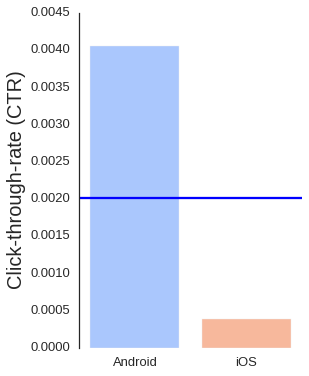

In [7]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([0.0040529381907986935,0.0003888820490178181])
f, (ax) = plt.subplots(1, 1, figsize=(4, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=.1,ax=ax)
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
ax.axhline(y=rate_all)
#ax.setup(ax.get_yticklabels(), fontsize=20)
sns.despine(bottom=True)

Add error bar:

In [80]:
binom_interval(3745,924021)

(0.0040529381907986935, 0.0039244118393998977, 0.0041845886269252786)

In [81]:
binom_interval(458,1177735)

(0.0003888820490178181, 0.00035408394543559146, 0.0004261743492227632)

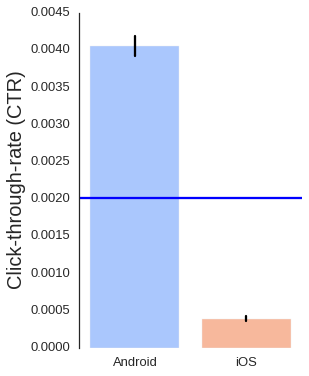

In [86]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([0.0040529381907986935,0.0003888820490178181])
f, (ax) = plt.subplots(1, 1, figsize=(4, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=0,ax=ax)
plt.ylim([0, 0.0045])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
ax.axhline(y=0.002017591303004998)
sns.despine(bottom=True)
plt.plot([0,0], [0.0039244118393998977, 0.0041845886269252786], 'k-')
plt.plot([1,1], [0.00035408394543559146, 0.0004261743492227632], 'k-')

#What's Android vs iOS for each country?

USA Android:

In [10]:
usa_a = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
usa_a

0.0007981787642804592

USA iOS:

In [11]:
usa_i = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
usa_i

0.0001486752474414299

In [68]:
ita_a = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_i = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
gbr_a = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
gbr_i = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
nga_a = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
nga_i = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
print 'ITA Android: %.4f\nITA iOS: %.4f\nGBR Android: %.4f\nGBR iOS: %.4f\nNGA Android: %.4f\nNGA iOS: %.4f\n' % (ita_a,ita_i,gbr_a,gbr_i,nga_a,nga_i)

ITA Android: 0.0047
ITA iOS: 0.1176
GBR Android: 0.0186
GBR iOS: 0.0017
NGA Android: 0.0046
NGA iOS: 0.0028



In [14]:
es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

657

In [69]:
usa_rate = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_rate = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
gbr_rate = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
nga_rate = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
print 'USA: %.4f\nITA %.4f\nGBR: %.4f\nNGA: %.4f\n' % (usa_rate,ita_rate,gbr_rate,nga_rate)

USA: 0.0006
ITA 0.0047
GBR: 0.0030
NGA: 0.0031



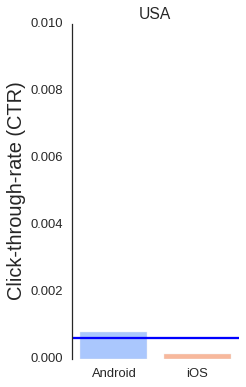

In [29]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([usa_a,usa_i])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=.1,ax=ax)
plt.ylim([0, 0.01])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("USA")
ax.axhline(y=usa_rate)
sns.despine(bottom=True)

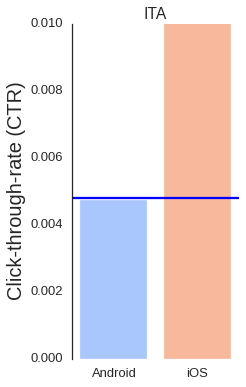

In [28]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([ita_a,ita_i])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=.1,ax=ax)
plt.ylim([0, 0.01])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("ITA")
ax.axhline(y=ita_rate)
sns.despine(bottom=True)

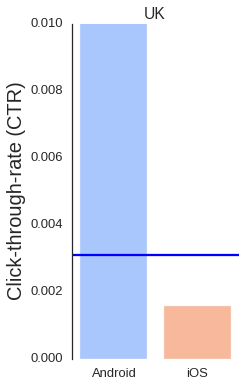

In [30]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([gbr_a,gbr_i])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=.1,ax=ax)
plt.ylim([0, 0.01])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("UK")
ax.axhline(y=gbr_rate)
sns.despine(bottom=True)

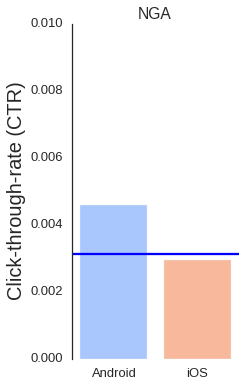

In [31]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([nga_a,nga_i])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=.1,ax=ax)
plt.ylim([0, 0.01])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("NGA")
ax.axhline(y=nga_rate)
sns.despine(bottom=True)

#Timestamp - local or same time zone?

In [ ]:
clicks_uniq['created_at']

In [ ]:
data2[data2['br_short'] == 'Android'].shape[0]

#CTR on different ads and app pairs

I have looked at that CTR varies across all apps. How about ads?

In [ ]:
plt.figure(figsize=(20,5))
p = data2.groupby('cr').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.04),title='CTR across ads')
plt.axhline(y=rate)

In [ ]:
plt.figure(figsize=(20,5))
p = data2.groupby('cr').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,5000000),title='number of events per ads')
p.set_yscale('log')

For a given ad, how different app differ in CTR?

Super targeted (1 app): 214, 285, 289, 290

<= 5 app: 250, 256, 275

Diverse:

In [ ]:
cr = 289
plt.figure(figsize=(20,5))
p = data2[data2['cr'] == cr].groupby('ai').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,0.01),title='CTR across app')

Number of apps per ads:

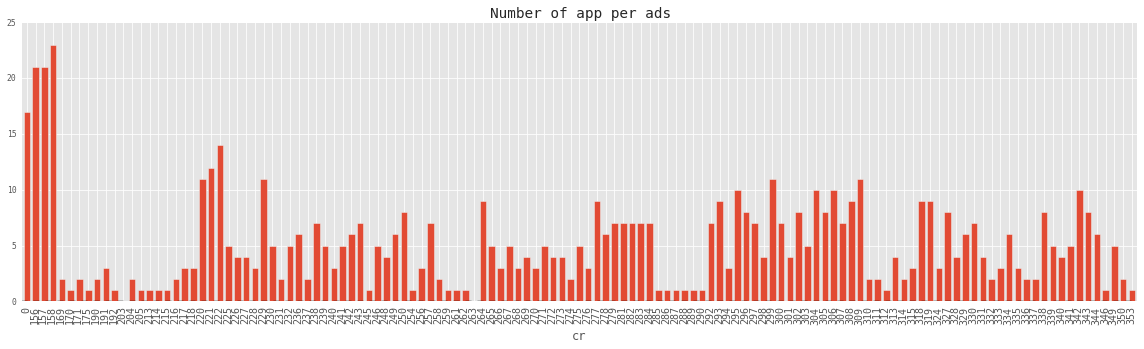

In [355]:
plt.figure(figsize=(20,5))
data2.groupby('cr').apply(lambda x: len(np.unique(x['ai'].dropna()))).sort_index().plot(kind='bar',title='Number of app per ads')

For a given app, how different ads differ in CTR?

Good ads for DC: (158), 214, (241), 285, 289, 290, (331, 333)

In [ ]:
plt.figure(figsize=(20,5))
p = data2_app1.groupby('cr').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,50000),title='number of events per ads (app1)')
p.set_yscale('log')

In [ ]:
plt.figure(figsize=(20,5))
p = data2_app2.groupby('cr').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.006),title='CTR across ads (app2)')
plt.axhline(y=rate_app2)

Good ads for TM: 156, 256, 275, 298

In [ ]:
plt.figure(figsize=(20,5))
p = data2_app2.groupby('cr').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,200000),title='number of events per ads (app2)')
p.set_yscale('log')

In [ ]:
plt.figure(figsize=(8,4))
p = data2_app3.groupby('cr').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.02),title='CTR across ads (app3)')
plt.axhline(y=rate_app3

In [ ]:
plt.figure(figsize=(8,4))
p = data2_app3.groupby('cr').apply(lambda x:(x.click.sum() + (~x.click).sum()/impression_sample_rate)).plot(kind='bar',color='b',ylim=(.5,20000),title='number of events per ads (app3)')
p.set_yscale('log')

In [ ]:
len(np.unique(data2[data2['cr'] == 275]['ai'].dropna()))

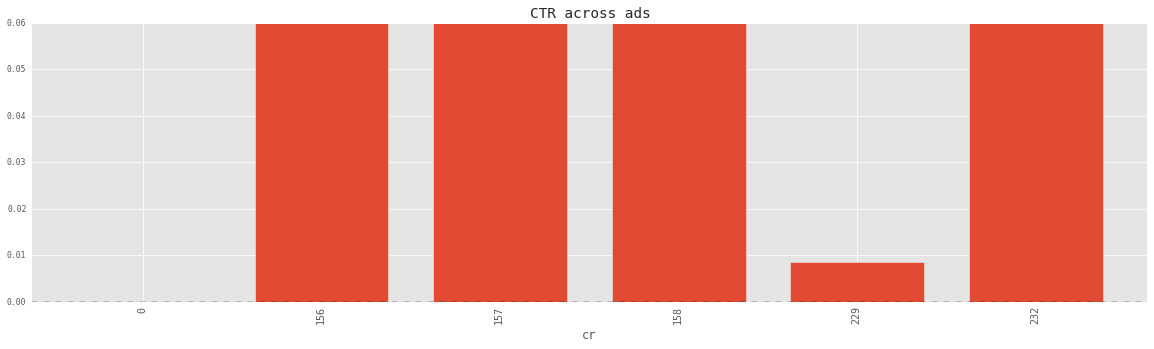

In [356]:
aid = 108
plt.figure(figsize=(20,5))
p = data2[data2['ai'] == aid].groupby('cr').apply(lambda x:float(x.click.sum())/((~x.click).sum()/impression_sample_rate + x.click.sum())).sort_index().plot(kind='bar',logy=True,ylim=(0,.06),title='CTR across ads')

#Full-scale ads and app "interaction"

Get raw data directly from the elastic database:

In [301]:
es = Elasticsearch([{'host': eslogin.host, 'port': eslogin.port}],http_auth=(eslogin.user,eslogin.password))

Test

In [302]:
es.count(index="events-2015.05.*", body={'query': {'bool': {'must':[{'match': { 'ai' : 67 }}, {'match': { 'cr' : 289 }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

1048

In [314]:
len(np.unique(data2['ai'].dropna()))

43

In [315]:
len(np.unique(data2['cr'].dropna()))

127

In [277]:
columns = [53,54,67,68,71,72]
index = [156, 256, 275, 298, 214, 285, 289, 290, 327, 334, 343]
df_show = pd.DataFrame(index=index, columns=columns)
df_show = df_show.fillna(0)
df_show

,53,54,67,68,71,72
156,0,0,0,0,0,0
256,0,0,0,0,0,0
275,0,0,0,0,0,0
298,0,0,0,0,0,0
214,0,0,0,0,0,0
285,0,0,0,0,0,0
289,0,0,0,0,0,0
290,0,0,0,0,0,0
327,0,0,0,0,0,0
334,0,0,0,0,0,0


Get data from May 2015

In [278]:
for col in columns:
    for ind in index:
        df_show.loc[ind,col] = es.count(index="events-2015.05.*", body={'query': {'bool': {'must':[{'match': { 'ai' : col }}, {'match': { 'cr' : ind }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

In [279]:
df_show

,53,54,67,68,71,72
156,585,41948,51,53,0,0
256,13,1734,5,0,0,0
275,11,787,0,0,0,0
298,74,5999,0,0,0,0
214,0,67,0,1989,0,0
285,0,0,2257,0,0,0
289,0,0,1048,0,0,0
290,0,0,1435,0,0,0
327,0,0,0,0,0,0
334,0,0,0,0,0,0


In [280]:
df_click = pd.DataFrame(index=index, columns=columns)
df_click = df_click.fillna(0)
for col in columns:
    for ind in index:
        df_click.loc[ind,col] = es.count(index="events-2015.05.*", body={'query': {'bool': {'must':[{'match': { 'ai' : col }}, {'match': { 'cr' : ind }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']

In [281]:
df_click

,53,54,67,68,71,72
156,0,93,1,0,0,0
256,0,4,1,0,0,0
275,0,2,0,0,0,0
298,0,10,0,0,0,0
214,0,0,0,5,0,0
285,0,0,31,0,0,0
289,0,0,16,0,0,0
290,0,0,25,0,0,0
327,0,0,0,0,0,0
334,0,0,0,0,0,0


Get data from June 2015

In [282]:
df_show2 = pd.DataFrame(index=index, columns=columns)
df_show2 = df_show2.fillna(0)
for col in columns:
    for ind in index:
        df_show2.loc[ind,col] = es.count(index="events-2015.06.*", body={'query': {'bool': {'must':[{'match': { 'ai' : col }}, {'match': { 'cr' : ind }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
df_show2

,53,54,67,68,71,72
156,0,71,0,0,0,0
256,0,0,0,0,0,0
275,0,0,0,0,0,0
298,0,0,0,0,0,0
214,0,0,0,0,0,0
285,0,0,0,0,0,0
289,0,0,0,0,0,0
290,0,0,0,0,0,0
327,55,2743,197,32,260,10
334,78,4501,232,11,159,1


In [283]:
df_click2 = pd.DataFrame(index=index, columns=columns)
df_click2 = df_click2.fillna(0)
for col in columns:
    for ind in index:
        df_click2.loc[ind,col] = es.count(index="events-2015.06.*", body={'query': {'bool': {'must':[{'match': { 'ai' : col }}, {'match': { 'cr' : ind }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
df_click2

,53,54,67,68,71,72
156,0,0,0,0,0,0
256,0,0,0,0,0,0
275,0,0,0,0,0,0
298,0,0,0,0,0,0
214,0,0,0,0,0,0
285,0,0,0,0,0,0
289,0,0,0,0,0,0
290,0,0,0,0,0,0
327,0,2,0,0,5,0
334,0,9,0,0,4,0


In [285]:
df_show = df_show + df_show2
df_click = df_click + df_click2

In [321]:
df_show

,53,54,67,68,71,72
156,585,42019,51,53,0,0
256,13,1734,5,0,0,0
275,11,787,0,0,0,0
298,74,5999,0,0,0,0
214,0,67,0,1989,0,0
285,0,0,2257,0,0,0
289,0,0,1048,0,0,0
290,0,0,1435,0,0,0
327,55,2743,197,32,260,10
334,78,4501,232,11,159,1


In [322]:
df_click

,53,54,67,68,71,72
156,0,93,1,0,0,0
256,0,4,1,0,0,0
275,0,2,0,0,0,0
298,0,10,0,0,0,0
214,0,0,0,5,0,0
285,0,0,31,0,0,0
289,0,0,16,0,0,0
290,0,0,25,0,0,0
327,0,2,0,0,5,0
334,0,9,0,0,4,0


In [288]:
df_click / (df_show + 0.01)

,53,54,67,68,71,72
156,0,0.002213,0.019604,0.000000,0.000000,0
256,0,0.002307,0.199601,0.000000,0.000000,0
275,0,0.002541,0.000000,0.000000,0.000000,0
298,0,0.001667,0.000000,0.000000,0.000000,0
214,0,0.000000,0.000000,0.002514,0.000000,0
285,0,0.000000,0.013735,0.000000,0.000000,0
289,0,0.000000,0.015267,0.000000,0.000000,0
290,0,0.000000,0.017421,0.000000,0.000000,0
327,0,0.000729,0.000000,0.000000,0.019230,0
334,0,0.002000,0.000000,0.000000,0.025156,0


In [294]:
df_ctr = df_click / (df_show + 0.01)

In [344]:
df_ctr_logodd = np.log2(df_ctr/rate + 0.01)

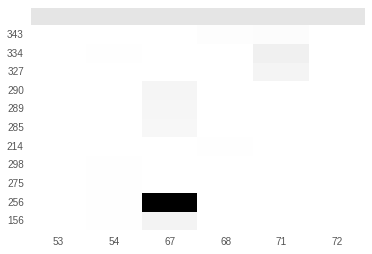

In [297]:
plt.pcolor(df_ctr)
plt.yticks(np.arange(0.5, len(df_ctr.index), 1), df_ctr.index)
plt.xticks(np.arange(0.5, len(df_ctr.columns), 1), df_ctr.columns)
plt.show()

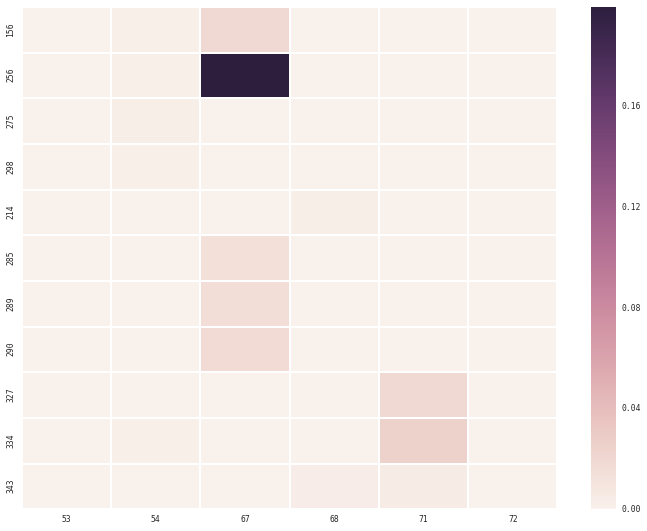

In [299]:
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(df_ctr, vmax=.8, linewidths=0, square=True)
sns.heatmap(df_ctr)

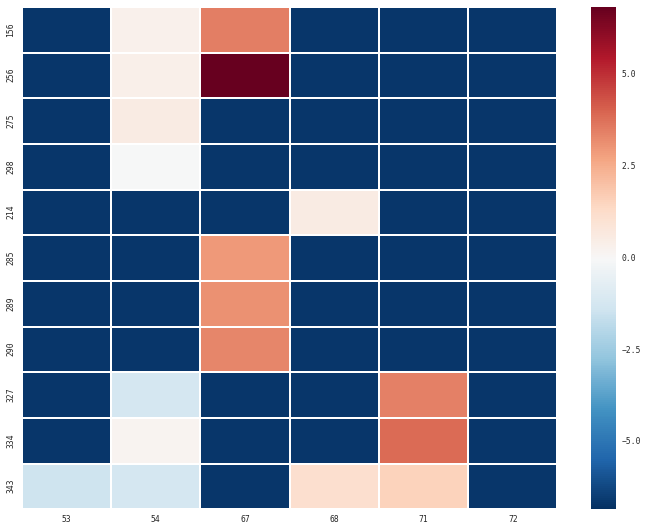

In [316]:
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_ctr_logodd)

In [342]:
df_ctr_logodd.loc[156,71] = np.nan

In [329]:
df_ctr_logodd

,53,54,67,68,71,72
156,-6.643856,0.353830,3.490668,-6.643856,NaN,-6.643856
256,-6.643856,0.413071,6.837408,-6.643856,-6.643856,-6.643856
275,-6.643856,0.551730,-6.643856,-6.643856,-6.643856,-6.643856
298,-6.643856,-0.051460,-6.643856,-6.643856,-6.643856,-6.643856
214,-6.643856,-6.643856,-6.643856,0.536169,-6.643856,-6.643856
285,-6.643856,-6.643856,2.977924,-6.643856,-6.643856,-6.643856
289,-6.643856,-6.643856,3.130304,-6.643856,-6.643856,-6.643856
290,-6.643856,-6.643856,3.320548,-6.643856,-6.643856,-6.643856
327,-6.643856,-1.225320,-6.643856,-6.643856,3.462906,-6.643856
334,-6.643856,0.208524,-6.643856,-6.643856,3.850119,-6.643856


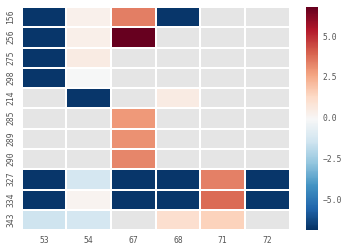

In [332]:
mask = df_show.apply(lambda x: x == 0)
sns.heatmap(df_ctr_logodd, mask=mask)

In [313]:
df_ctr

,53,54,67,68,71,72
156,0.000000,0.002213,0.019604,0.000000,0.000000,0
256,0.000000,0.002307,0.199601,0.000000,0.000000,0
275,0.000000,0.002541,0.000000,0.000000,0.000000,0
298,0.000000,0.001667,0.000000,0.000000,0.000000,0
214,0.000000,0.000000,0.000000,0.002514,0.000000,0
285,0.000000,0.000000,0.013735,0.000000,0.000000,0
289,0.000000,0.000000,0.015267,0.000000,0.000000,0
290,0.000000,0.000000,0.017421,0.000000,0.000000,0
327,0.000000,0.000729,0.000000,0.000000,0.019230,0
334,0.000000,0.002000,0.000000,0.000000,0.025156,0


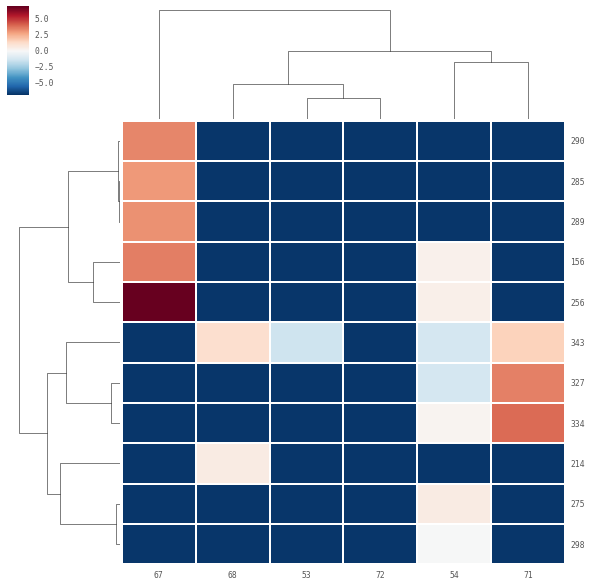

In [345]:
sns.clustermap(df_ctr_logodd)

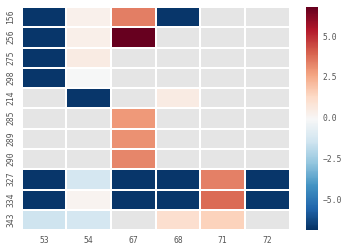

In [338]:
sns.heatmap(df_ctr_logodd, mask=mask)

In [346]:
columns_cluster = [67,68,53,72,54,71]
index_cluster = [290, 285, 289, 156, 256, 343, 327, 334, 214, 275, 298]

In [347]:
df_show_c = pd.DataFrame(index=index_cluster, columns=columns_cluster)
df_show_c = df_show_c.fillna(0)

In [348]:
for col in columns_cluster:
    for ind in index_cluster:
        df_show_c.loc[ind,col] = df_show.loc[ind,col]

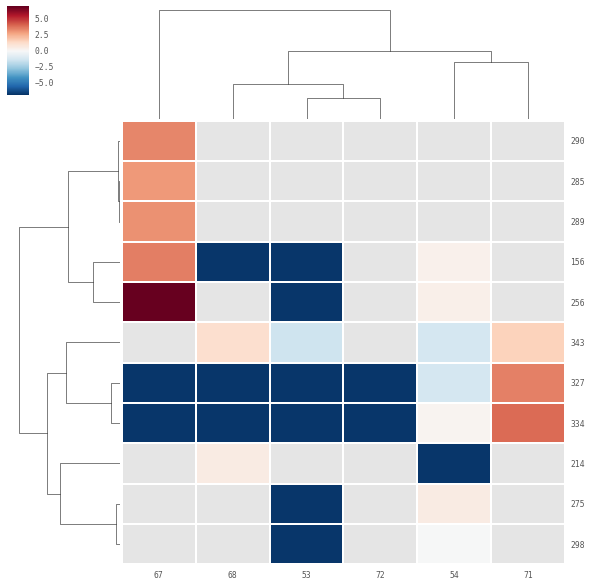

In [349]:
mask = df_show_c.apply(lambda x: x == 0)
sns.clustermap(df_ctr_logodd, mask=mask)

In [489]:
data2['cty'].value_counts().head()

London           1282
Lagos             965
Mountain View     239
Singapore         234
Kansas City       197
dtype: int64

#Refine plots

In [79]:
from scipy.stats import beta
def binom_interval(success, total, confint=0.95):
    quantile = (1 - confint) / 2.
    mode = float(success)/total
    lower = beta.ppf(quantile, success, total - success + 1)
    upper = beta.ppf(1 - quantile, success + 1, total - success)
    return (mode, lower, upper)

In [33]:
ita_a_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_a_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_i_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_i_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
print 'ITA android click: %d\nITA android show: %d\nITA iOS click: %d\nITA: %d\n' % (ita_a_click,ita_a_show,ita_i_click,ita_i_show)

ITA android click: 1781
ITA android show: 375391
ITA iOS click: 85
ITA: 717



In [36]:
binom_interval(1781,375391)

(0.004744386519655506, 0.0045270664868216296, 0.0049694046831056937)

In [37]:
binom_interval(85,717)

(0.11854951185495119, 0.095799659672383658, 0.1444907966490091)

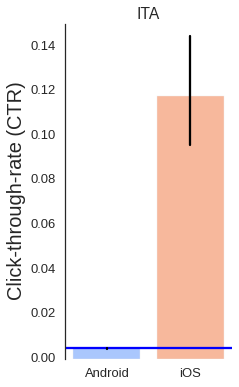

In [74]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([ita_a,ita_i])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=0,ax=ax)
plt.ylim([0, 0.15])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("ITA")
ax.axhline(y=ita_rate)
sns.despine(bottom=True)
plt.plot([1,1], [0.095799659672383658,0.1444907966490091], 'k-')
plt.plot([0,0], [0.0045270664868216296,0.0049694046831056937], 'k-')

In [55]:
np.std([1] * 3 + [0] * 2)

0.48989794855663565

In [61]:
def binom_error(success, total, confint=0.95):
    avg = float(success)/total
    err = np.std([1] * success + [0] * (total - success))/math.sqrt(total)
    return (avg, err)

In [62]:
binom_error(1781,375391)

(0.004744386519655506, 0.00011215416889568033)

In [63]:
binom_error(85,717)

(0.11854951185495119, 0.012072279131235047)

In [67]:
ita_i

0.1293759512937595

In [65]:
0.11854951185495119 + 0.012072279131235047

0.13062179098618623

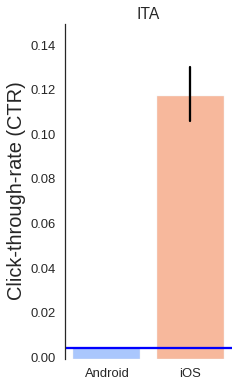

In [70]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([ita_a,ita_i])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=0,ax=ax)
plt.ylim([0, 0.15])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("ITA")
ax.axhline(y=ita_rate)
sns.despine(bottom=True)
plt.plot([1,1], [0.10647723272371615,0.13062179098618623], 'k-')

In [75]:
datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')

'2015-06-22 14:26:36'

In [79]:
usa_rate = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_rate = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
gbr_rate = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
nga_rate = float(es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count'])/es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
print 'USA: %.4f\nITA %.4f\nGBR: %.4f\nNGA: %.4f\n' % (usa_rate,ita_rate,gbr_rate,nga_rate)

USA: 0.0006
ITA 0.0047
GBR: 0.0030
NGA: 0.0032



In [76]:
ita_a_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_a_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_i_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
ita_i_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'ITA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
print 'ITA android click: %d\nITA android show: %d\nITA iOS click: %d\nITA: %d\n' % (ita_a_click,ita_a_show,ita_i_click,ita_i_show)

ITA android click: 1783
ITA android show: 376049
ITA iOS click: 85
ITA: 723



In [78]:
ita_a_stat = binom_interval(ita_a_click,ita_a_show)
ita_i_stat = binom_interval(ita_i_click,ita_i_show)

In [85]:
ita_a_stat[1:]

(0.0045243401221140012, 0.0049661513124962834)

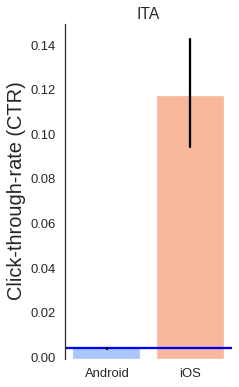

In [86]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([ita_a_stat[0],ita_i_stat[0]])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=0,ax=ax)
plt.ylim([0, 0.15])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("ITA")
ax.axhline(y=ita_rate)
sns.despine(bottom=True)
plt.plot([0,0], ita_a_stat[1:], 'k-')
plt.plot([1,1], ita_i_stat[1:], 'k-')

In [87]:
gbr_a_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
gbr_a_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
gbr_i_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
gbr_i_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'GBR' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
print 'GBR android click: %d\nGBR android show: %d\nGBR iOS click: %d\nGBR iOS show: %d\n' % (gbr_a_click,gbr_a_show,gbr_i_click,gbr_i_show)

GBR android click: 855
GBR android show: 45937
GBR iOS click: 44
GBR iOS show: 26234



In [88]:
gbr_a_stat = binom_interval(gbr_a_click,gbr_a_show)
gbr_i_stat = binom_interval(gbr_i_click,gbr_i_show)

In [89]:
gbr_a_stat

(0.01861244748242158, 0.017396141325199066, 0.019890117829972187)

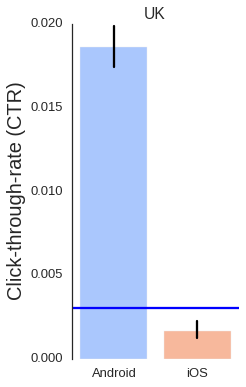

In [97]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([gbr_a_stat[0],gbr_i_stat[0]])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=0,ax=ax)
plt.ylim([0, 0.02])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("UK")
ax.axhline(y=gbr_rate)
sns.despine(bottom=True)
plt.plot([0,0], gbr_a_stat[1:], 'k-')
plt.plot([1,1], gbr_i_stat[1:], 'k-')

In [93]:
nga_a_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
nga_a_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
nga_i_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
nga_i_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'NGA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
print 'NGA android click: %d\nNGA android show: %d\nNGA iOS click: %d\nNGA iOS show: %d\n' % (nga_a_click,nga_a_show,nga_i_click,nga_i_show)

NGA android click: 881
NGA android show: 190055
NGA iOS click: 114
NGA iOS show: 40374



In [94]:
nga_a_stat = binom_interval(nga_a_click,nga_a_show)
nga_i_stat = binom_interval(nga_i_click,nga_i_show)

In [95]:
nga_a_stat

(0.004635500249927652, 0.0043350604529966558, 0.0049511991949953149)

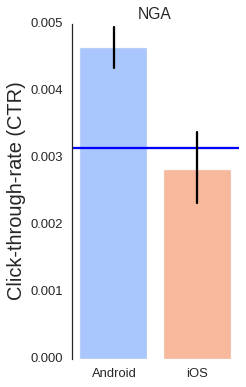

In [98]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([nga_a_stat[0],nga_i_stat[0]])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=0,ax=ax)
plt.ylim([0, 0.005])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("NGA")
ax.axhline(y=nga_rate)
sns.despine(bottom=True)
plt.plot([0,0], nga_a_stat[1:], 'k-')
plt.plot([1,1], nga_i_stat[1:], 'k-')

In [99]:
usa_a_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
usa_a_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'android' }}, {'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
usa_i_click = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_CLICK' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
usa_i_show = es.count(index="events-*", body={'query': {'bool': {'must':[{'match': { 'plfm' : 'ios' }}, {'match': { 'co' : 'USA' }}, {'match': { 'et' : 'AD_SHOW' }}], 'must_not':[{'match': { 'fr' : 'true' }}]}}})['count']
print 'USA android click: %d\nUSA android show: %d\nUSA iOS click: %d\nUSA iOS show: %d\n' % (usa_a_click,usa_a_show,usa_i_click,usa_i_show)

USA android click: 233
USA android show: 289230
USA iOS click: 162
USA iOS show: 1070791



In [100]:
usa_a_stat = binom_interval(usa_a_click,usa_a_show)
usa_i_stat = binom_interval(usa_i_click,usa_i_show)

In [101]:
usa_a_stat

(0.0008055872489022577, 0.00070549538019229105, 0.00091588940947995301)

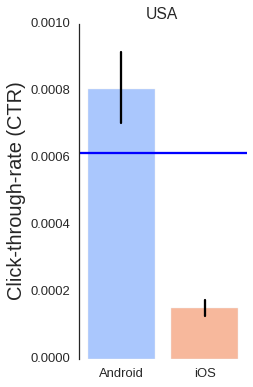

In [103]:
sns.set(style="white", context="talk")
x = np.array(['Android','iOS'])
y = np.array([usa_a_stat[0],usa_i_stat[0]])
f, (ax) = plt.subplots(1, 1, figsize=(3, 6), sharex=True)
p = sns.barplot(x, y, ci=None, palette="coolwarm", hline=0,ax=ax)
plt.ylim([0, 0.001])
ax.set_ylabel("Click-through-rate (CTR)",fontsize=20)
plt.title("USA")
ax.axhline(y=usa_rate)
sns.despine(bottom=True)
plt.plot([0,0], usa_a_stat[1:], 'k-')
plt.plot([1,1], usa_i_stat[1:], 'k-')

#specific app and ads

In [124]:
ids1 = (data2['plfm'] == 'ios').values

In [125]:
ids2 = (data2['co'] == 'ITA').values

In [127]:
ids = ids1 * ids2

In [131]:
data2.loc[ids,:]['cr'].value_counts()

229    2
333    1
214    1
...
229    2
333    1
214    1
0      1
Length: 4, dtype: int64

In [138]:
data2[data2['cr'] == 229]['co'].value_counts()

USA    184
ITA     13
FRA      5
VEN      4
VNM      3
GEO      2
JPN      2
ALB      2
ISR      2
PHL      2
MOZ      2
IND      1
BGD      1
HKG      1
ESP      1
BEL      1
ARE      1
IDN      1
AUT      1
THA      1
PAK      1
SWE      1
ARG      1
NOR      1
SGP      1
TUR      1
RUS      1
TTO      1
SAU      1
...
USA    184
ITA     13
FRA      5
VEN      4
VNM      3
GEO      2
JPN      2
ALB      2
ISR      2
PHL      2
MOZ      2
IND      1
BGD      1
HKG      1
ESP      1
BEL      1
ARE      1
IDN      1
AUT      1
THA      1
PAK      1
SWE      1
ARG      1
NOR      1
SGP      1
TUR      1
RUS      1
TTO      1
SAU      1
CZE      1
Length: 30, dtype: int64

In [139]:
data2[data2['cr'] == 333]['co'].value_counts()

ITA    75
UKR     1
dtype: int64

In [140]:
data2[data2['cr'] == 214]['co'].value_counts()

ITA    11
dtype: int64

In [141]:
data2[data2['cr'] == 333]['ai'].value_counts()

71    53
68    21
99     2
dtype: int64

In [142]:
data2[data2['cr'] == 214]['ai'].value_counts()

68    5
dtype: int64

In [143]:
data2[data2['cr'] == 333]['plfm'].value_counts()

ios    2
dtype: int64

In [144]:
data2[data2['cr'] == 214]['plfm'].value_counts()

ios    1
dtype: int64

In [146]:
data2[data2['ai'] == 71]['plfm'].value_counts()

Series([], dtype: int64)

#Convert UTC to local time by city

In [2]:
cities = json.load(open("../data/city_location_150624.txt"))

In [6]:
data = pd.read_csv("../data/data_150624.tab",sep='\t',index_col=0,encoding='utf-8')

In [12]:
import settings
from geopy import geocoders
g = geocoders.GoogleV3(settings.google_api_key)
timezone = g.timezone((lat, lng))

In [19]:
from datetime import datetime
date_object = datetime.strptime(data['created_at'][0], '%Y-%m-%d %H:%M:%S')
date_object

datetime.datetime(2015, 5, 10, 4, 41, 11)

In [20]:
data['created_at'] = data['created_at'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [21]:
import pytz
tz = pytz.timezone(timezone.zone)
utc = data['created_at'][0]
utc = utc.replace(tzinfo=pytz.utc)
local = tz.normalize(utc.astimezone(tz))
local

datetime.datetime(2015, 5, 10, 5, 41, 11, tzinfo=<DstTzInfo 'Europe/London' BST+1:00:00 DST>)

In [23]:
data.shape

(30912, 22)

In [24]:
def utc_to_local(time, city):
    try:
        #time.sleep(1)
        # get the local time zone
        (place, lat, lng) = cities[city]
        timezone = g.timezone((lat, lng))
        tz = pytz.timezone(timezone.zone)
    
        # convert UTC to local
        utc = time.replace(tzinfo=pytz.utc)
        local = tz.normalize(utc.astimezone(tz))
    
        return local
        
    except:
        return np.NaN

In [29]:
for i in data.index:
    data.loc[i,'local'] = utc_to_local(data.loc[i,'created_at'], data.loc[i,'cty'])

In [44]:
def get_day(x):
    if isinstance(x, float):
        return np.NaN
    else:
        return x.day
def get_hour(x):
    if isinstance(x, float):
        return np.NaN
    else:
        return x.hour

In [43]:
data['day'] = data['local'].apply(get_day)

In [45]:
data['hour'] = data['local'].apply(get_hour)

In [46]:
data.to_csv("../data/data_localtime_150624_2.tab",sep='\t',encoding='utf-8')

In [47]:
data['local'].apply(lambda x: isinstance(x, float)).sum()

28415

In [50]:
data['hour'].apply(lambda x: math.isnan(x)).sum()

28415

In [53]:
float(28415) / 30912

0.9192223084886129

over 90% do not have local time successfully assigned... I may reached the limitation again somehow...

In [61]:
data.index[~data['local'].apply(lambda x: isinstance(x, float))][2496]

25711

In [63]:
utc_to_local(data.loc[30000,'created_at'], data.loc[30000,'cty'])

nan

Hmm maybe not...

In [64]:
data['click'][~data['local'].apply(lambda x: isinstance(x, float))].value_counts()

0    1649
1     848
dtype: int64

In [66]:
def cty_parser(city):
    if type(city) == float:
        return city
    else:
        return city.encode('ascii', 'ignore').decode('ascii')

In [67]:
data2 = pd.concat([data[['click']],pd.get_dummies(data['br_short'], dummy_na=True, prefix='br'),
                   pd.get_dummies(data['co'], dummy_na=True, prefix='co'),
                   pd.get_dummies(data['cty'].apply(cty_parser), dummy_na=True, prefix='cty'),
                   pd.get_dummies(data['rgn'], dummy_na=True, prefix='rgn'),
                   pd.get_dummies(data['plfm'], dummy_na=True, prefix='plfm'),
                   pd.get_dummies(data['pv'], dummy_na=True, prefix='pv'),
                   pd.get_dummies(data['dt'], dummy_na=True, prefix='dt'),
                   pd.get_dummies(data['isp'], dummy_na=True, prefix='isp'),
                   pd.get_dummies(data['ad_type'], dummy_na=True, prefix='ad_type'),
                   data[['ai','cr','sdpt','ernc','dp']]],axis=1)

In [68]:
data_exp = data2.drop(['br_nan'], axis=1)

In [70]:
data_exp.loc[:,'br_nan'] = 0 * data_exp.shape[0]
for i in data_exp.index:
    data_exp.loc[i,'br_nan'] = data2.ix[:,12][i] + data2.ix[:,13][i]

In [71]:
data_exp.to_csv("../data/data_localtime_expanded_150624.tab",sep='\t',encoding='utf-8')

#Plot time dependece

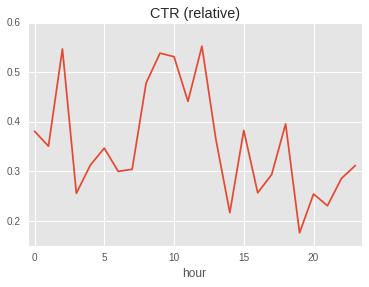

In [77]:
data[~data['local'].apply(lambda x: isinstance(x, float))].groupby('hour').apply(lambda x:float(x.click.sum())/x.shape[0]).sort_index().plot(xlim=(-.5,23.5), title='CTR (relative)')

In [72]:
data[~data['local'].apply(lambda x: isinstance(x, float))].shape

(2497, 24)

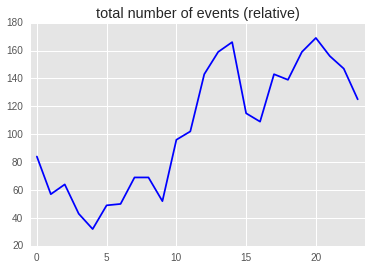

In [78]:
data[~data['local'].apply(lambda x: isinstance(x, float))]['hour'].value_counts().sort_index().plot(color="b",xlim=(-.5,23.5), title='total number of events (relative)')